# To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import variation
from scipy.stats import wilcoxon
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sb
import pingouin as pg
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
plt.rcParams['font.size'] = '30'

In [3]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s20', 's175', 's178', 's180', 's181', 's182', 's183', 's189', 's190', 's198', 's207', 's209', 's210', 's212',
          's217', 's219', 's224']

In [4]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)
# print(all_trials)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'bigram #': 'bigram_num', 'Bigram': 'bigram'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = typ.correct_filter(all_bigrams) ## excludes all bigrams in an error trial
incorr_trials_bybg = typ.incorrect_filter(all_bigrams)

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.corr_bigram]).reset_index(drop=True) ## excludes only incorrect bigrams 
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.corr_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [5]:
all_bigrams.to_csv('all_bigrams.csv')
# all_bigrams['corr_bigram'].unique()
# filtered = all_bigrams[(all_bigrams.IKI > 2)]
# filtered

all_bigrams[[type(x) != str for x in list(all_bigrams.corr_bigram)]]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(all_bigrams)

,sID,Bigram #,trial,bigram_loc,bigram,corr_bigram,IKI,string,resp_string,rep #,bg_freq,bf_type,meanbf_type,wf_type
423,s209,423,106,4,ka,NaN,0.120064,zibja,aibjka,3,NaN,NaN,low,pseudo
587,s209,587,147,4,we,NaN,0.000000,there,therwe,7,NaN,NaN,high,high
794,s209,794,199,4,rm,NaN,0.031981,kremp,ktrermp,6,NaN,NaN,med,pseudo
795,s209,795,199,5,mp,NaN,0.192041,kremp,ktrermp,6,NaN,NaN,med,pseudo
1379,s198,423,106,4,ka,NaN,0.120064,zibja,aibjka,3,NaN,NaN,low,pseudo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15135,s189,795,199,5,mp,NaN,0.192041,kremp,ktrermp,6,NaN,NaN,med,pseudo
15719,s219,423,106,4,ka,NaN,0.120064,zibja,aibjka,3,NaN,NaN,low,pseudo
15883,s219,587,147,4,we,NaN,0.000000,there,therwe,7,NaN,NaN,high,high
16090,s219,794,199,4,rm,NaN,0.031981,kremp,ktrermp,6,NaN,NaN,med,pseudo


In [6]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram"for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in ID_list:
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    return errs

In [7]:
## Making dataframe of IKI stats
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [8]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['corr_bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['corr_bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'corr_bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['corr_bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

# STATS
___

In [9]:
ages = [22 ,25, 20, 19, 25, 25, 26, 19, 19, 18, 25, 19, 22, 21, 19]
print(stat.mean(ages))
print(stat.stdev(ages))

21.6
2.8735244660769563


In [10]:
# anova for means (by bg freq)
# high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
# high_iki['bf_type'] = 'high'
# med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
# med_iki['bf_type'] = 'med'
# low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
# low_iki['bf_type'] = 'low'

# ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
print(ikis)

iki_anova = pg.rm_anova(ikis, 'mean', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'mean', 'bf_type', effsize='cohen')

       sID corr_bigram      mean bf_type
0     s175          ab  0.195218     Med
1     s175          am  0.101299     Med
2     s175          an  0.279057    High
3     s175          ao  0.175091     Low
4     s175          aq  0.328009     Low
...    ...         ...       ...     ...
1236  s224          vo  0.128782     Low
1237  s224          wo  0.095213     Med
1238  s224          yk  0.268012     Low
1239  s224          ze  0.190401     Low
1240  s224          zi  0.152031     Low

[1241 rows x 4 columns]
    Source  ddof1  ddof2    F  p-unc  ng2
0  bf_type      2     32  inf    0.0  1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,High,Low,0.171569,0.163629,0.007940,0.004838,1.641002,2.288353e-01,0.110333
1,High,Med,0.171569,0.146155,0.025414,0.004687,5.421958,2.121255e-07,0.398007
2,Low,Med,0.163629,0.146155,0.017475,0.004049,4.315437,5.107842e-05,0.323425


In [11]:
## anova for cvs (by bg freq)
# high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
# high_cv['bf_type'] = 'high'
# med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)
# med_cv['bf_type'] = 'med'
# low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
# low_cv['bf_type'] = 'low'

# cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
print(cvs)

cv_anova = pg.rm_anova(cvs, 'variation', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'variation', 'bf_type', effsize='cohen')

       sID corr_bigram  variation bf_type
0     s175          ab   0.082272     Med
1     s175          am   0.189591     Med
2     s175          an   1.583724    High
3     s175          ao   0.564267     Low
4     s175          aq   0.370019     Low
...    ...         ...        ...     ...
1236  s224          vo   0.371073     Low
1237  s224          wo   0.217132     Med
1238  s224          yk   0.372215     Low
1239  s224          ze   0.386954     Low
1240  s224          zi   0.400669     Low

[1241 rows x 4 columns]
    Source  ddof1  ddof2    F  p-unc  ng2
0  bf_type      2     32  inf    0.0  1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,High,Low,0.413052,0.292177,0.120875,0.018967,6.372993,7.825762e-10,0.428605
1,High,Med,0.413052,0.274330,0.138722,0.018375,7.549575,1.388889e-13,0.476262
2,Low,Med,0.292177,0.274330,0.017847,0.015874,1.124301,4.992312e-01,0.109406


In [12]:
## anova for sds (by bg freq)
# high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
# high_sd['bf_type'] = 'high'
# med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)
# med_sd['bf_type'] = 'med'
# low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)
# low_sd['bf_type'] = 'low'

# sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)

print(sds)

sd_anova = pg.rm_anova(sds, 'std', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'std', 'bf_type', effsize='cohen')

       sID corr_bigram       std bf_type
0     s175          ab  0.016930     Med
1     s175          am  0.020370     Med
2     s175          an  0.468758    High
3     s175          ao  0.104791     Low
4     s175          aq  0.129750     Low
...    ...         ...       ...     ...
1236  s224          vo  0.050372     Low
1237  s224          wo  0.021792     Med
1238  s224          yk  0.105154     Low
1239  s224          ze  0.077662     Low
1240  s224          zi  0.065120     Low

[1241 rows x 4 columns]
    Source  ddof1  ddof2    F  p-unc  ng2
0  bf_type      2     32  inf    0.0  1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,High,Low,0.096454,0.052767,0.043687,0.005574,7.838025,0.000000,0.497190
1,High,Med,0.096454,0.044226,0.052228,0.005400,9.672146,0.000000,0.602695
2,Low,Med,0.052767,0.044226,0.008540,0.004665,1.830802,0.159976,0.219059


In [13]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2    F  p-unc  ng2
0  bf_type      2     32  inf    0.0  1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,4.0,8.0,-4.0,0.0,-inf,0.0,-inf
1,high,med,4.0,7.0,-3.0,0.0,-inf,0.0,-inf
2,low,med,8.0,7.0,1.0,0.0,inf,0.0,inf


In [14]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.high_avgbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.med_avgbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.low_avgbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2    F  p-unc  ng2
0  bf_type      2     32  inf    0.0  1.0


,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,high,low,3.0,4.0,-1.0,0.0,-inf,0.0,-inf
1,high,med,3.0,9.0,-6.0,0.0,-inf,0.0,-inf
2,low,med,4.0,9.0,-5.0,0.0,-inf,0.0,-inf


In [15]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_means(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_avgcvs(tight_bgs, 'bigram', typ.highbf).sort_values(by = 'Avg CV IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [17]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

,sID,skew,mean IKI
0,s20,5.852693,0.149656
1,s175,5.852693,0.149656
2,s178,5.852693,0.149656
3,s180,5.852693,0.149656
4,s181,5.852693,0.149656
5,s182,5.852693,0.149656
6,s183,5.852693,0.149656
7,s189,5.852693,0.149656
8,s190,5.852693,0.149656
9,s198,5.852693,0.149656


# GRAPHS
___

## Data Visualization
___

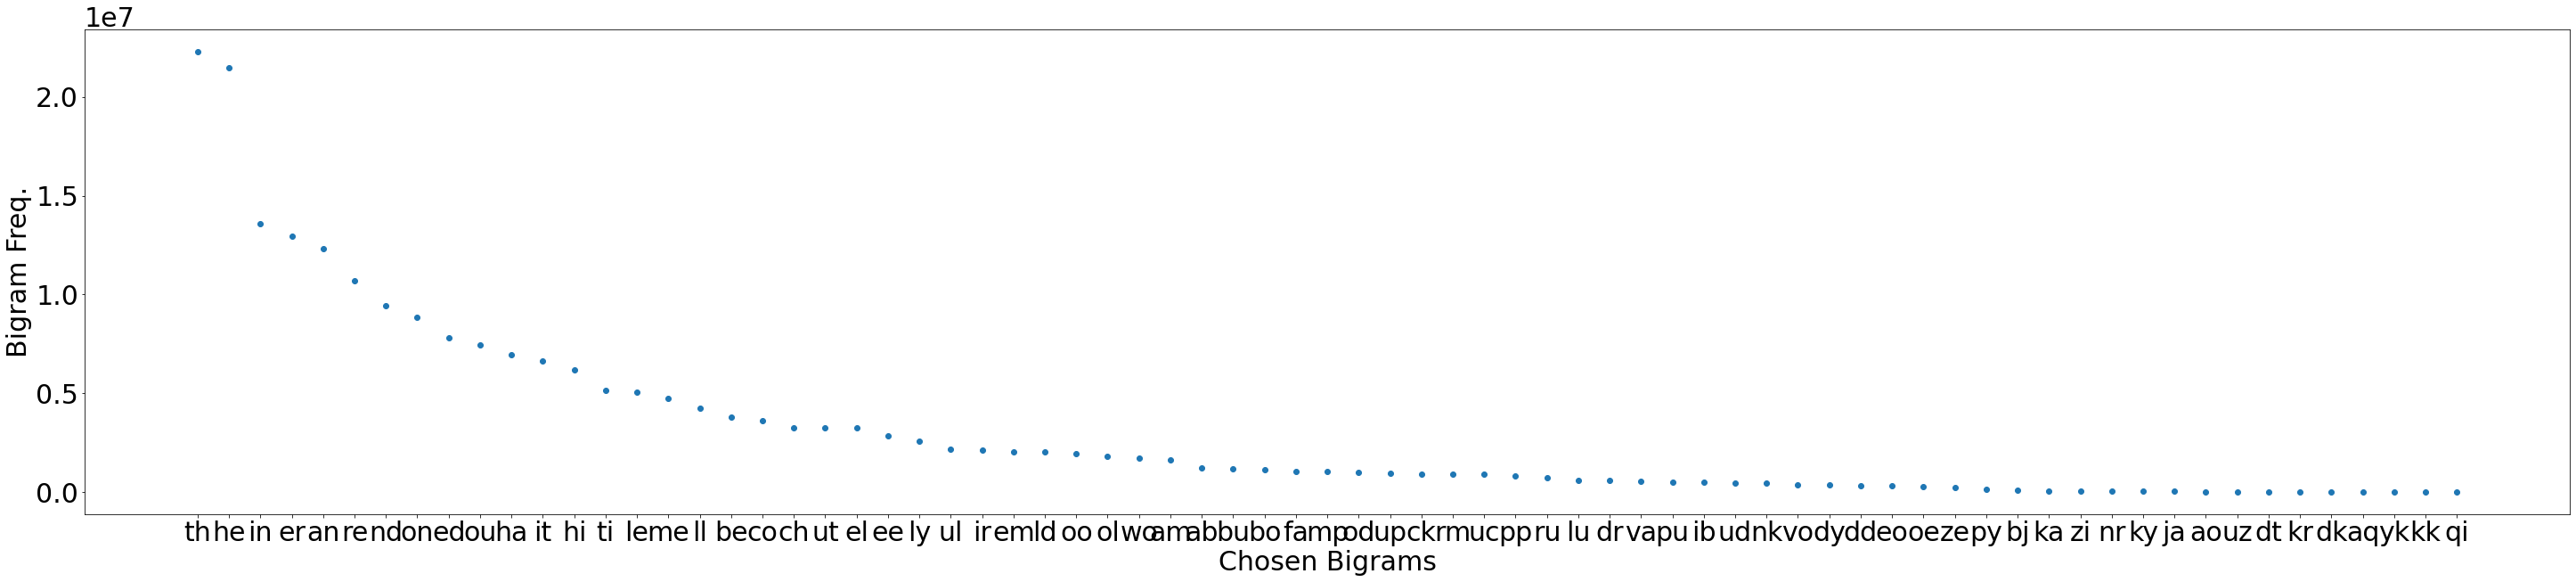

In [18]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

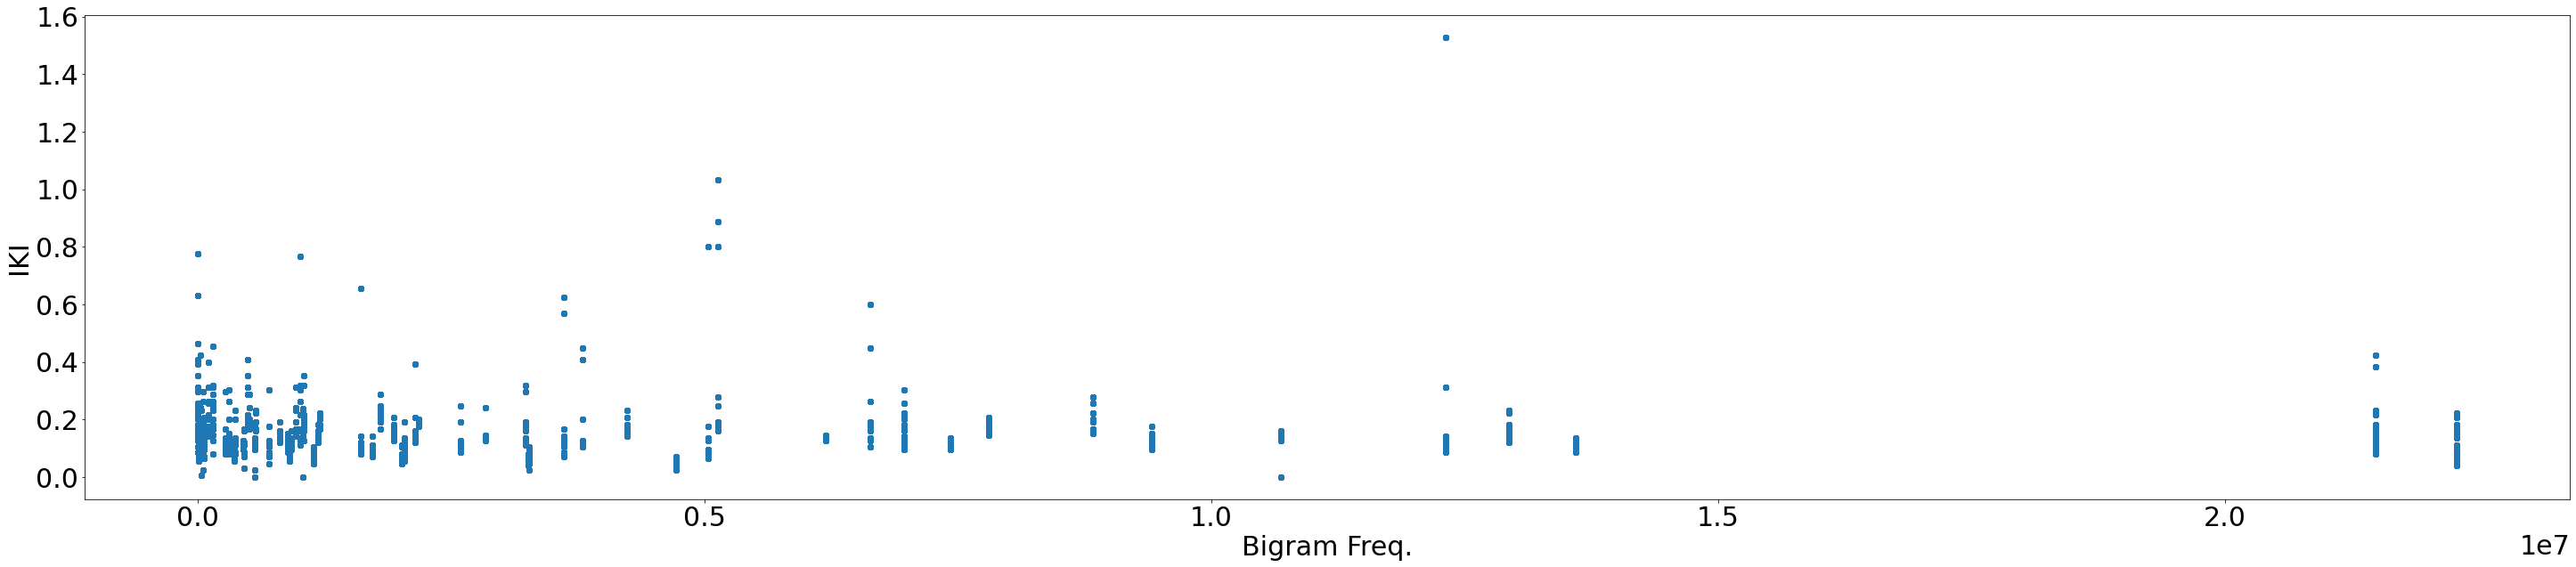

In [19]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

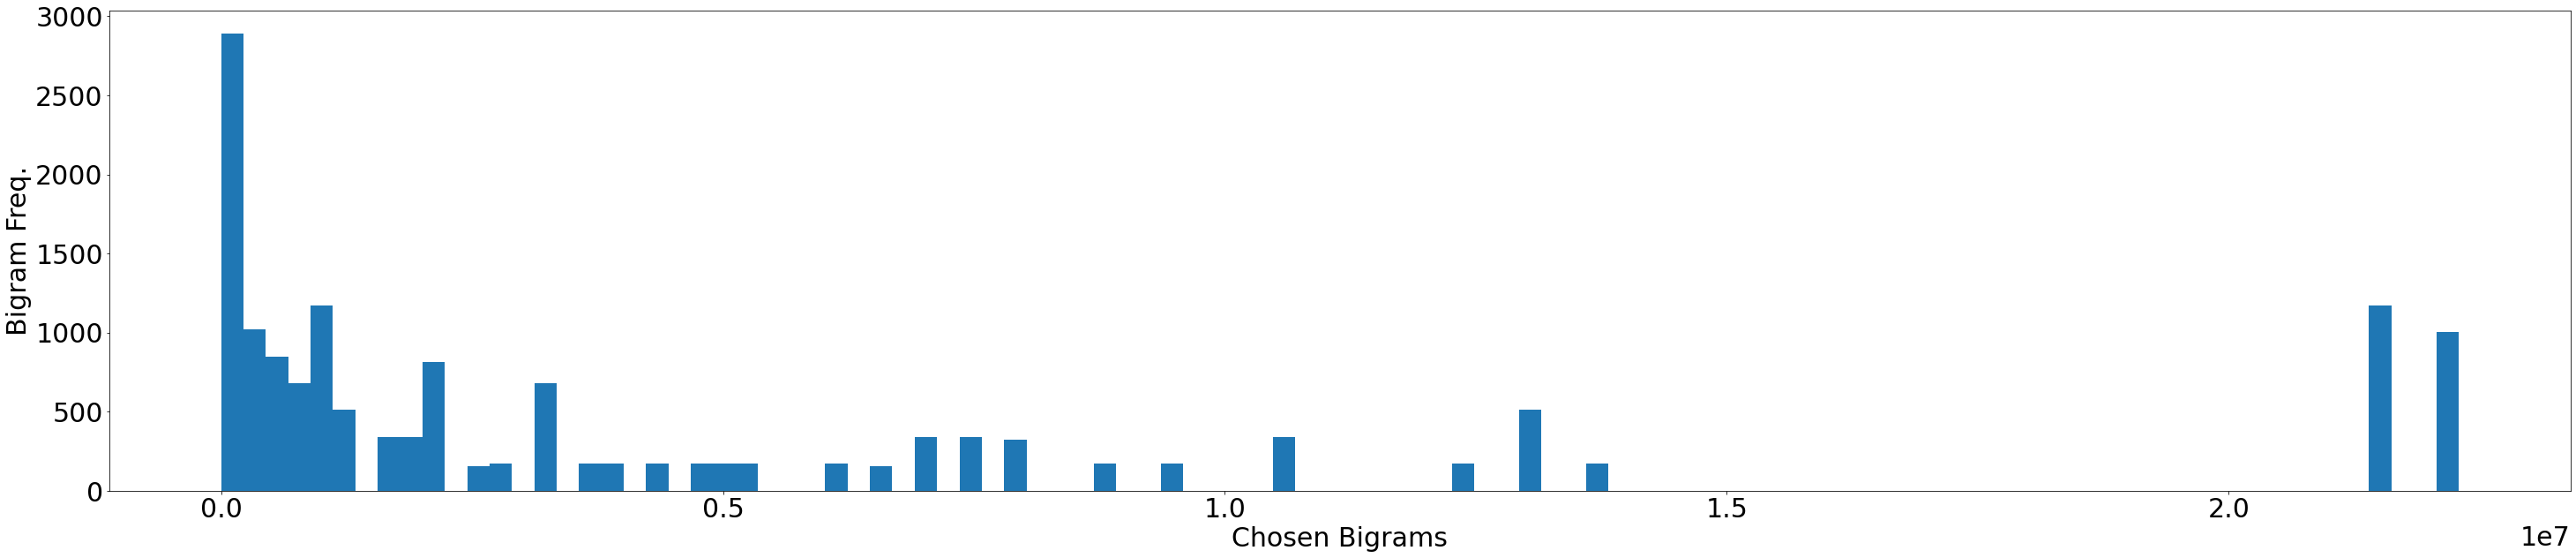

In [20]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

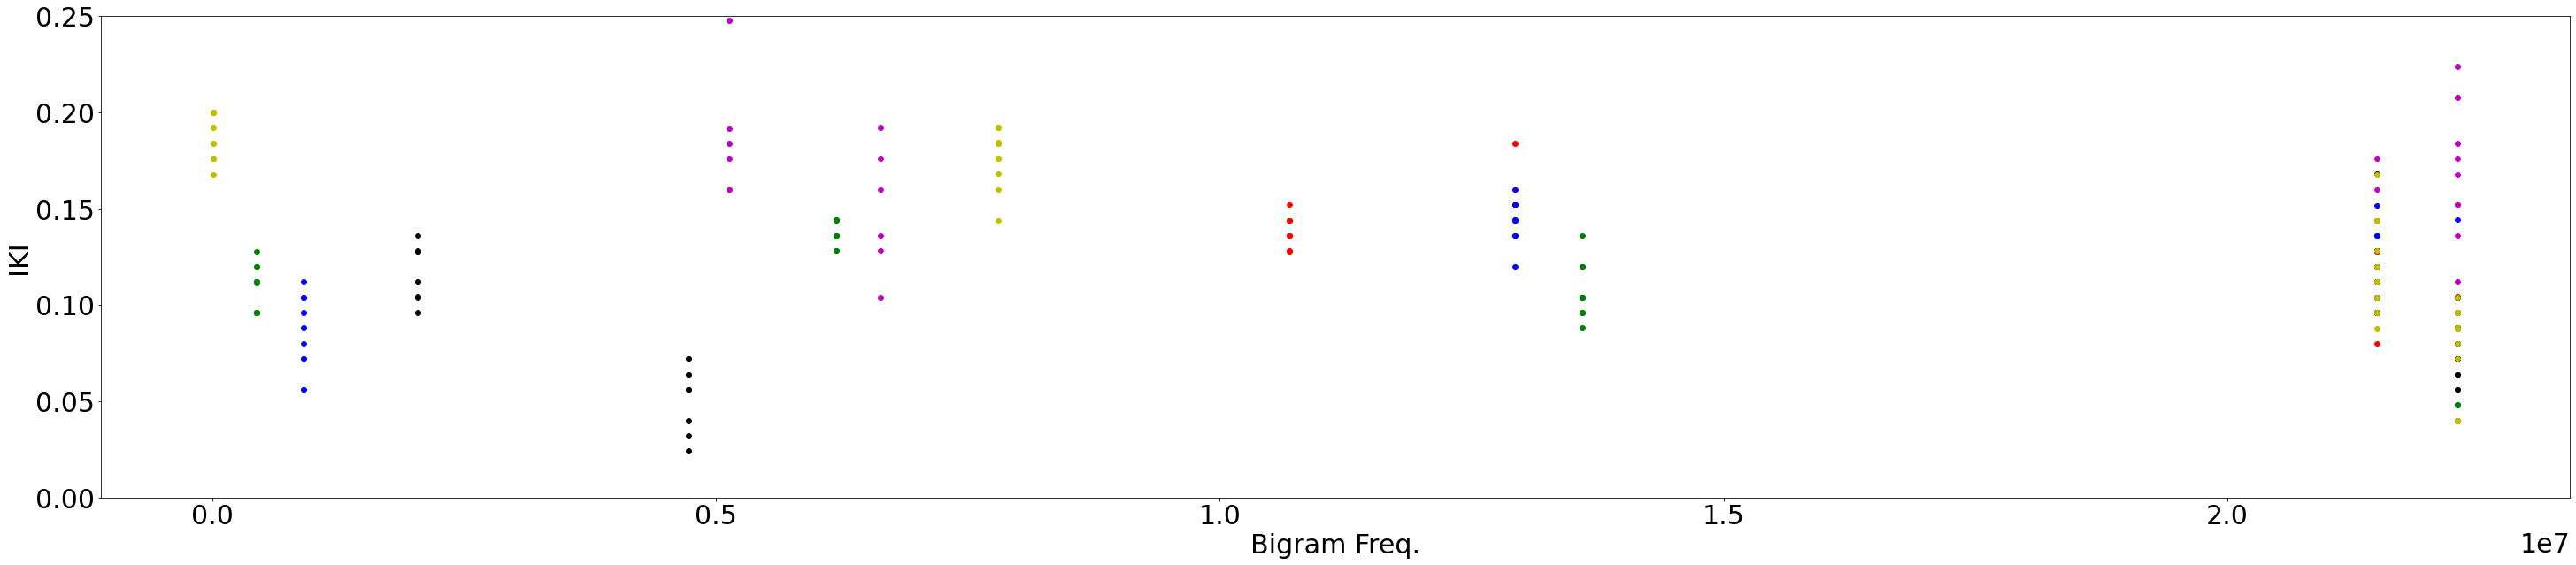

In [21]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sb.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

## Mean IKI GRAPHS
___

In [22]:
# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

In [23]:
indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)

,sID,Avg IKI
0,s175,0.16323
1,s178,0.16323
2,s180,0.16323
3,s181,0.16323
4,s182,0.16323
5,s183,0.16323
6,s189,0.16323
7,s190,0.16323
8,s198,0.16323
9,s20,0.16323


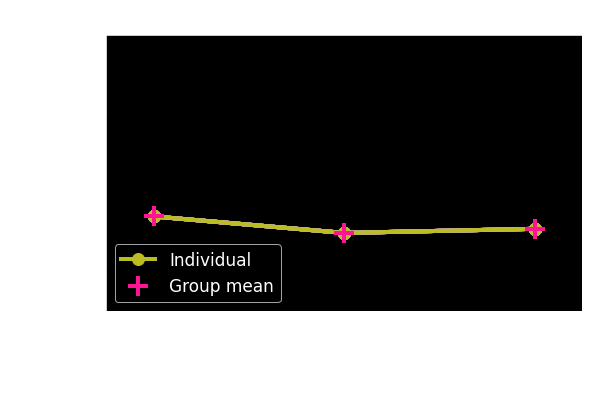

In [24]:
## individual IKI means by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

### Creates unique range of colors dependent on number of lines plotted -- useful if you plot more than 20 participants in one graph
## Current color map has 20 unique colors
# color = cm.rainbow(np.linspace(0, 1, len(ID_list)))
# for i, c in zip(range(len(ID_list)), color):
#     plt.plot(x, [l[i] for l in D], '.-', linewidth = 2.5, ms = 20, c = c)

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.04, 0.4])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

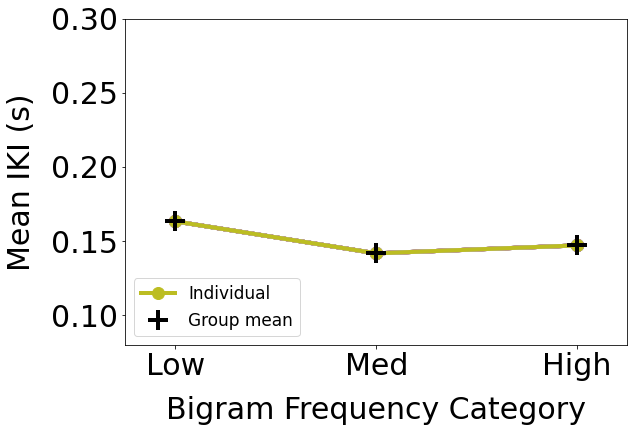

In [25]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.3])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

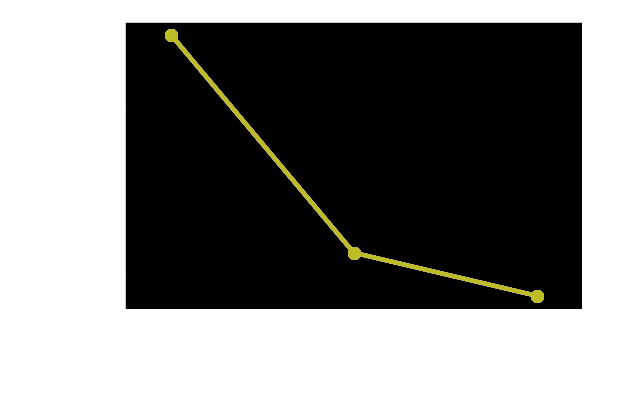

In [26]:
## individual IKI means by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'string', typ.low_avgbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.med_avgbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.high_avgbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, transparent = True)
plt.show()

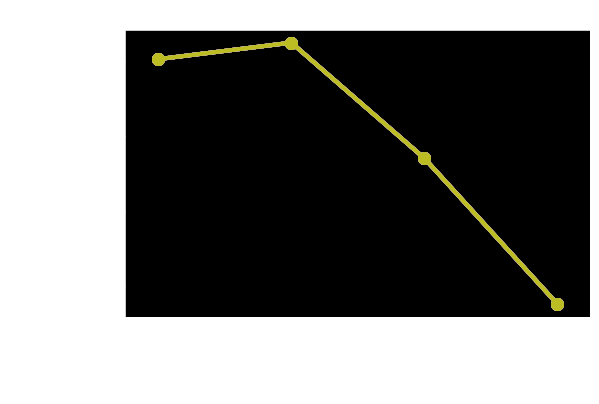

In [27]:
## individual IKI means by WF category (tight trials only -- correct and within 2 SD)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6, 8]
D = (indiv_means(tight_bgs, 'string', typ.pseudo)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.lowwf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.medwf)['Avg IKI'],
    indiv_means(tight_bgs, 'string', typ.highwf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

## CV GRAPHS
___

In [28]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', typ.highbf),
    indiv_avgcvs(all_bigrams, 'bigram', typ.medbf).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
cv_df

,sID,meanCV_high,meanCV_med,meanCV_low
0,s175,0.418286,0.297179,0.315299
1,s178,0.418286,0.297179,0.315299
2,s180,0.418286,0.297179,0.315299
3,s181,0.418286,0.297179,0.315299
4,s182,0.418286,0.297179,0.315299
5,s183,0.418286,0.297179,0.315299
6,s189,0.418286,0.297179,0.315299
7,s190,0.418286,0.297179,0.315299
8,s198,0.418286,0.297179,0.315299
9,s20,0.418286,0.297179,0.315299


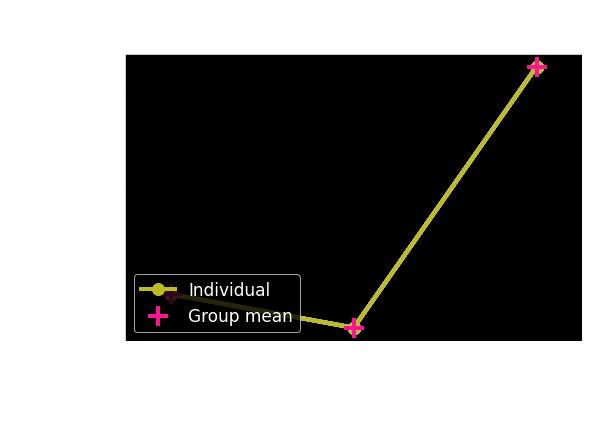

In [29]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

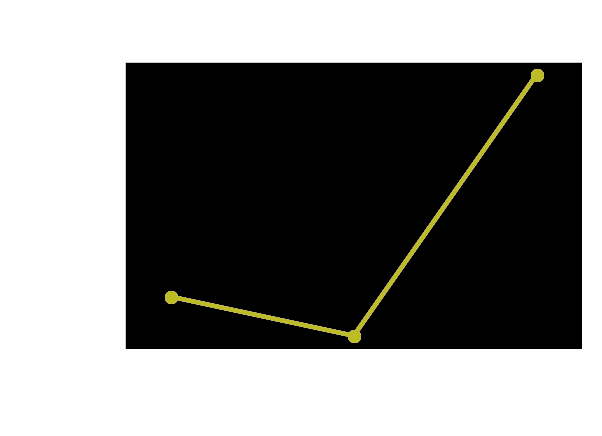

In [30]:
## Inividual MEAN CV IKIs by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

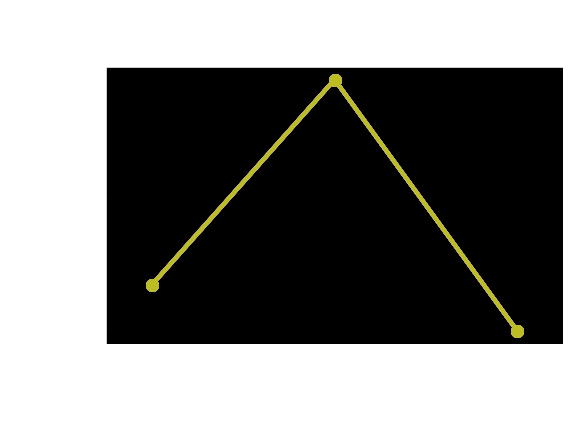

In [31]:
## Individual MEAN CV IKI by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.low_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.med_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.high_avgbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

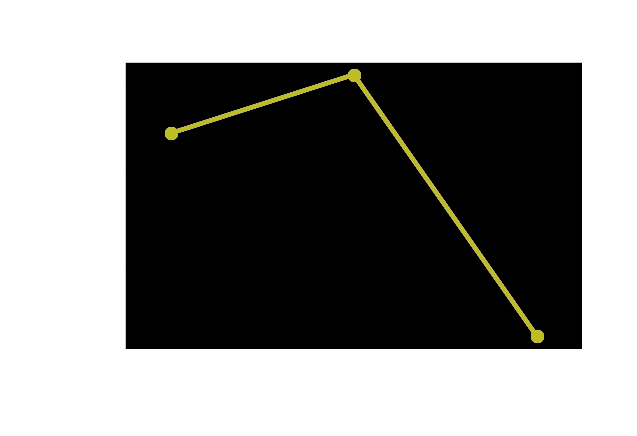

In [32]:
# individual MEAN CV IKIs by AVG BF category (tight_bgs df)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(tight_bgs, 'string', typ.low_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.med_avgbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.high_avgbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

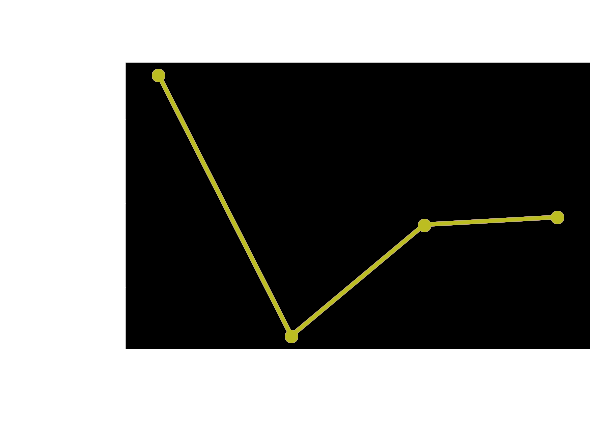

In [33]:
## individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

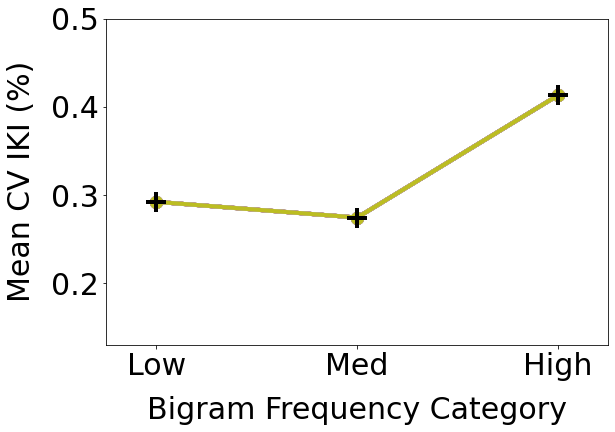

In [34]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

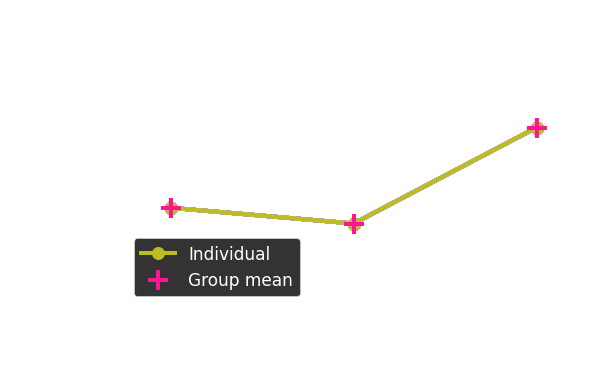

In [35]:
## individual MEAN SD IKI by BF (correct trials)
ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.15])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

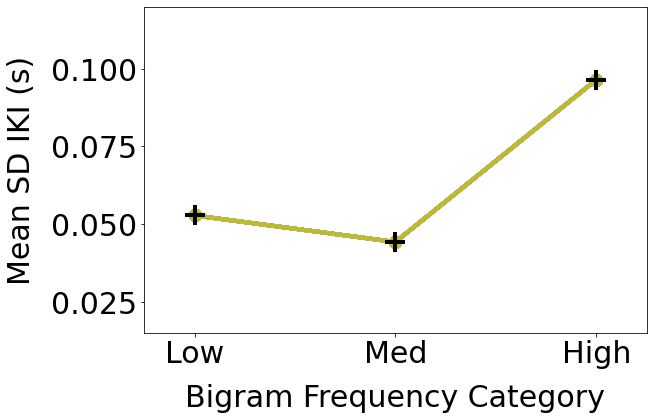

In [36]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

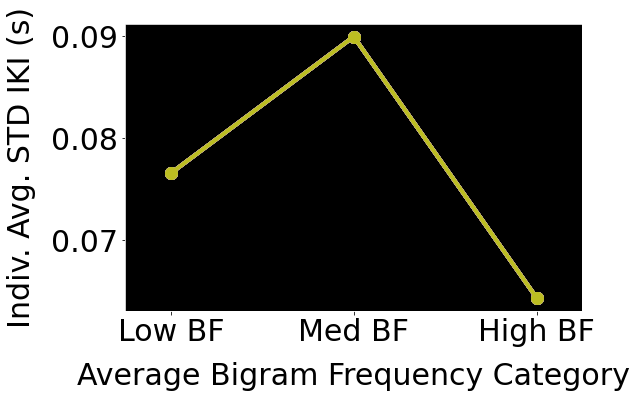

In [37]:
## individual MEAN SD IKI by AVG BF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.low_avgbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.med_avgbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.high_avgbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

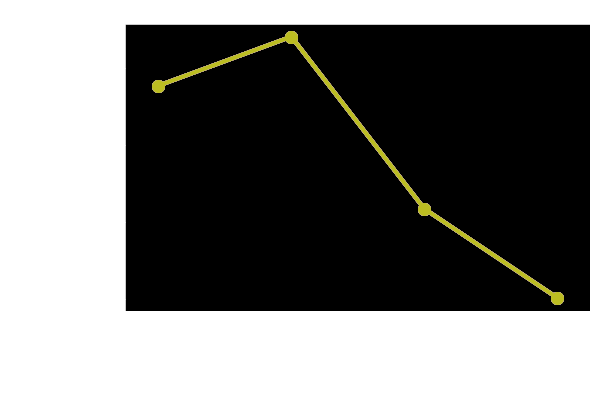

In [38]:
## individual MEAN SD IKI by WF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## BG FREQ GRAPHS
___

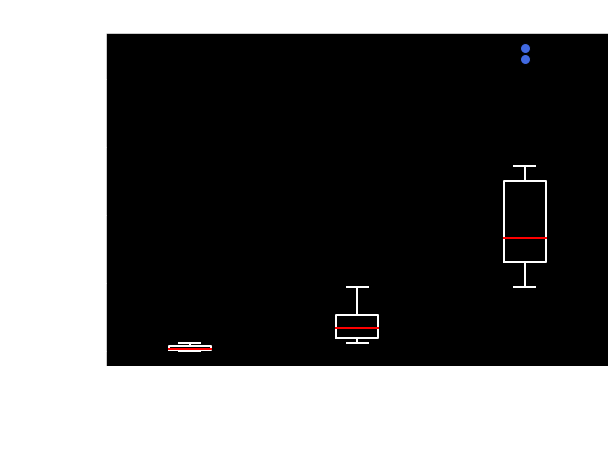

In [39]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('wf.png', dpi=300)
plt.show()

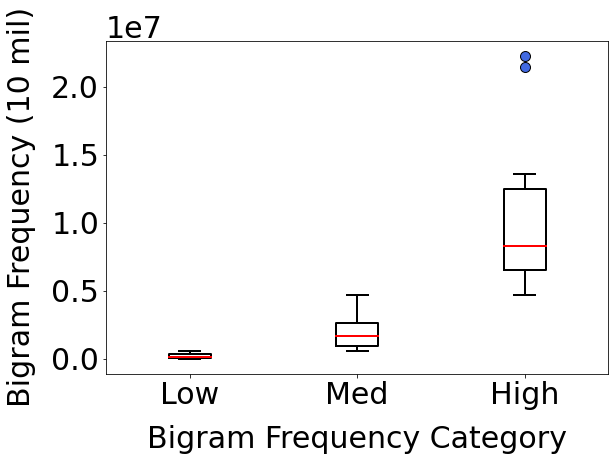

In [40]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## ERROR GRAPHS
___

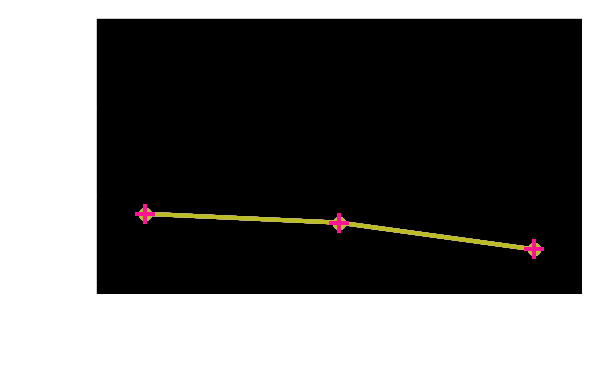

In [41]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error'])
means = (np.mean(indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 30])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

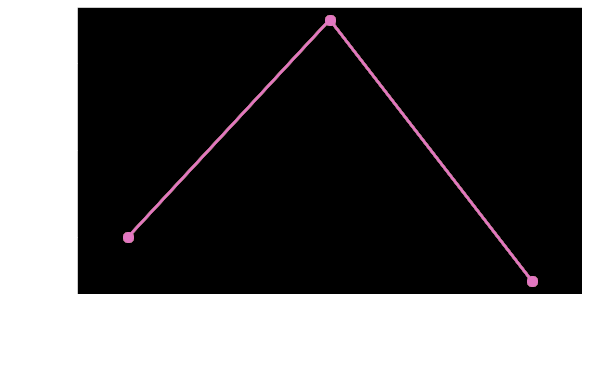

In [42]:
## Individual total trial error by AVG BF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_trials, 'string', typ.low_avgbf)['Total Error'], 
     indiv_error(incorr_trials, 'string', typ.med_avgbf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.high_avgbf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

[17, 17, 17, 17]


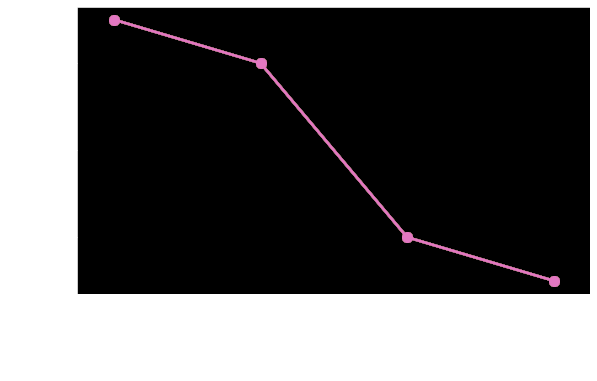

In [43]:
## Individual total trial error by WF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]

D = (indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

print([len(x) for x in D])
ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## Bigram-Word Interaction
___

In [44]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

<AxesSubplot:>

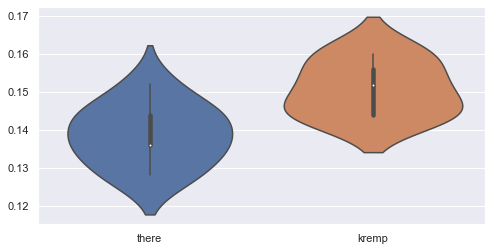

In [45]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 're' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's178') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with_onesub)

<AxesSubplot:>

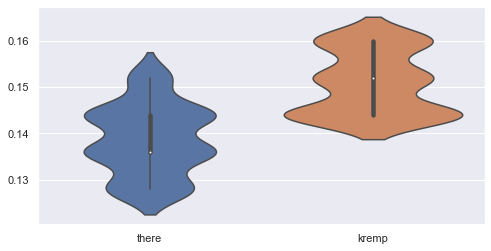

In [46]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<AxesSubplot:>

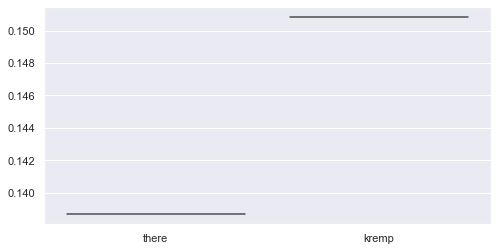

In [47]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

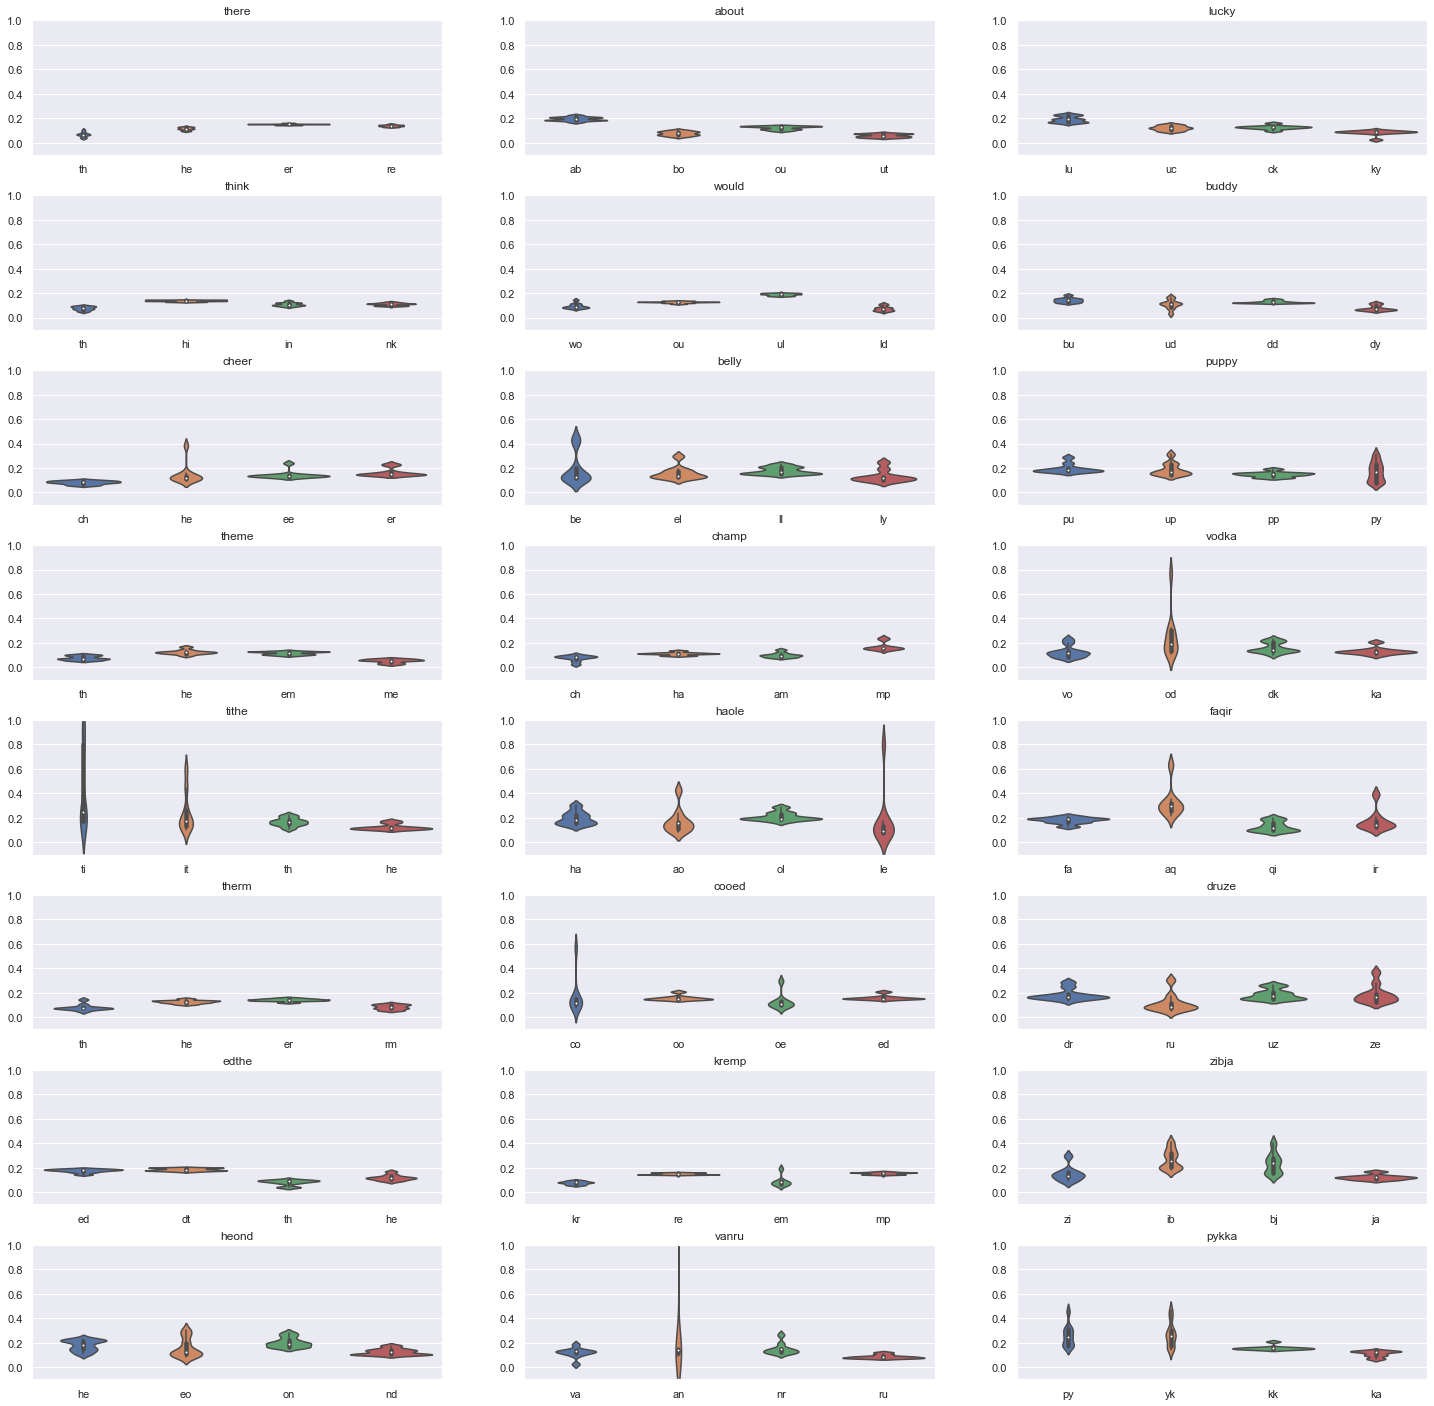

In [48]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

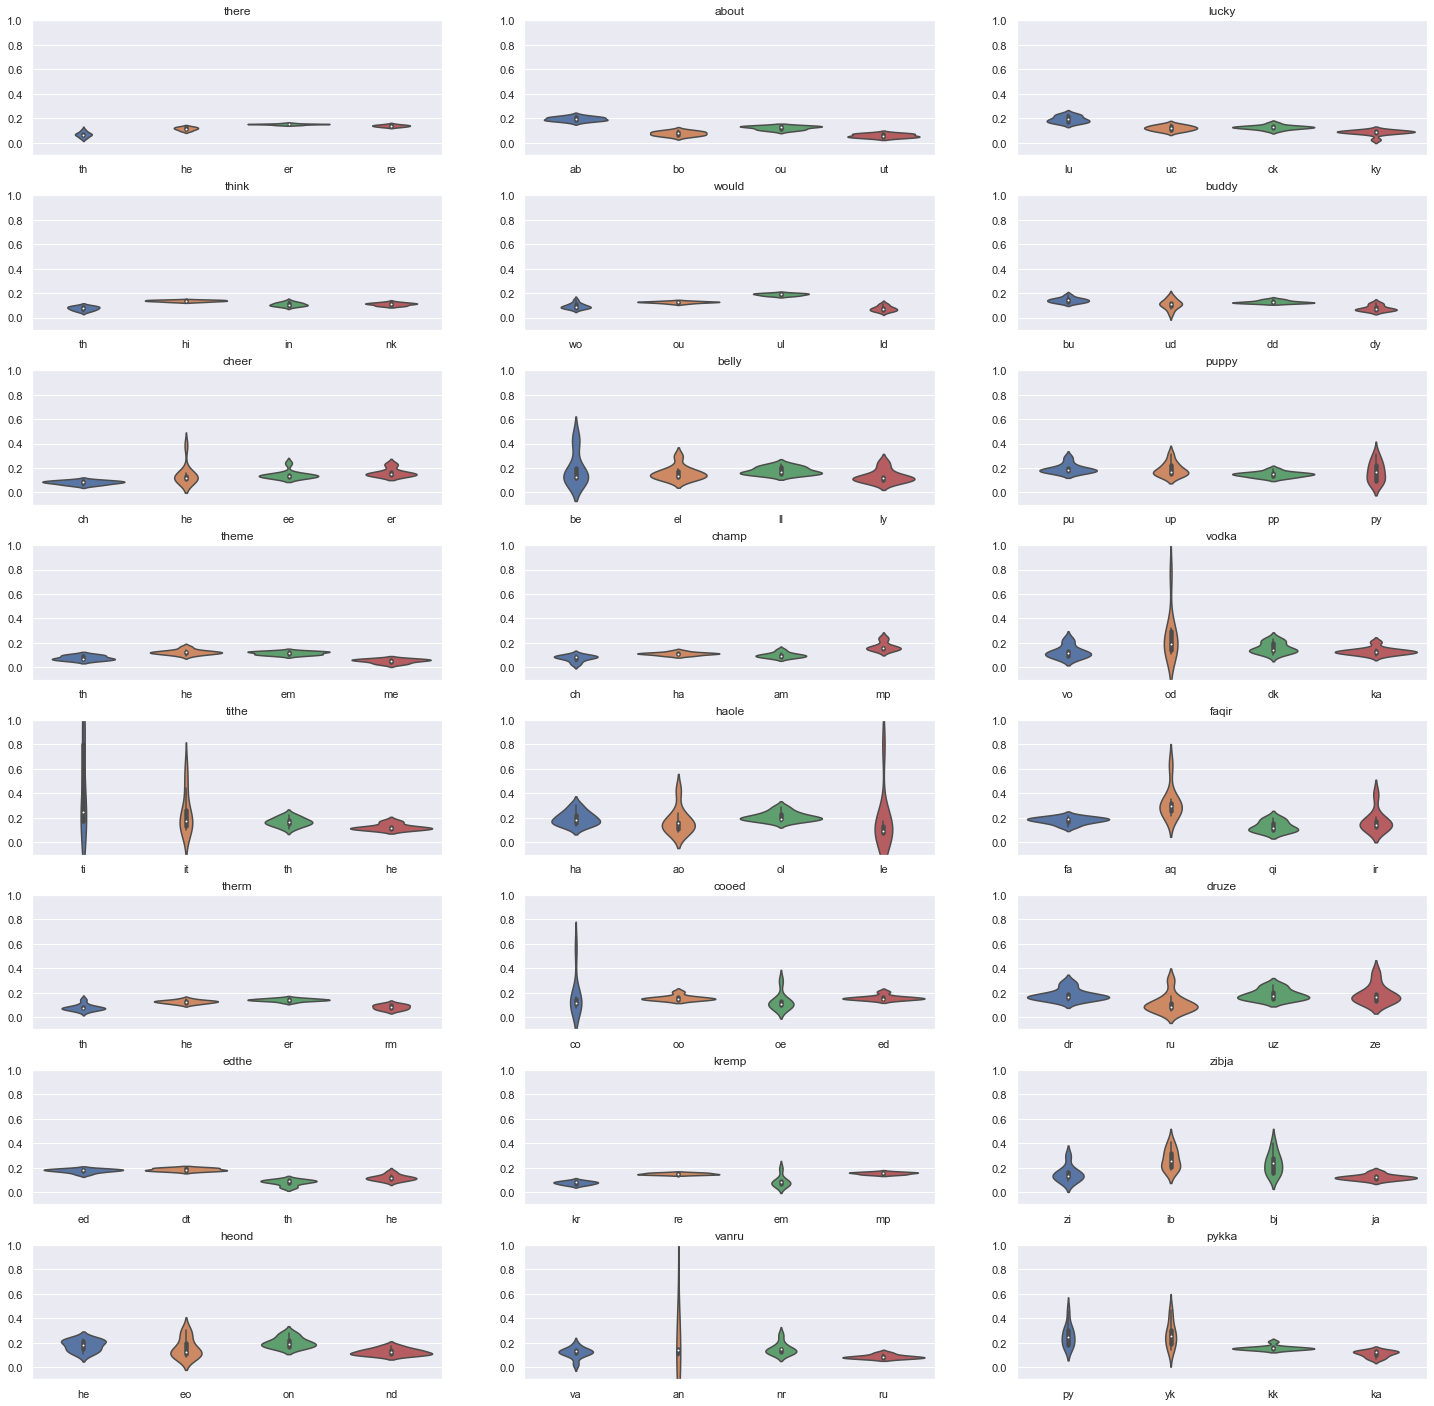

In [49]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

[Text(0.5, 1.0, 'there')]

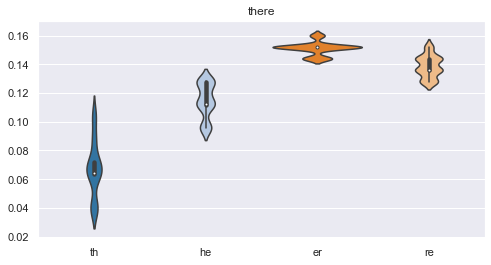

In [50]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'there' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='tab20').set(title = string)

# fig, ax = plt.subplots()
# violin = ax.violinplot(DF)
# for pc in violin["bodies"]:
#     pc.set_facecolor("green")
#     pc.set_edgecolor("black")
#     pc.set_alpha(0.5)

## KIND OF USEFUL GRAPHS
____

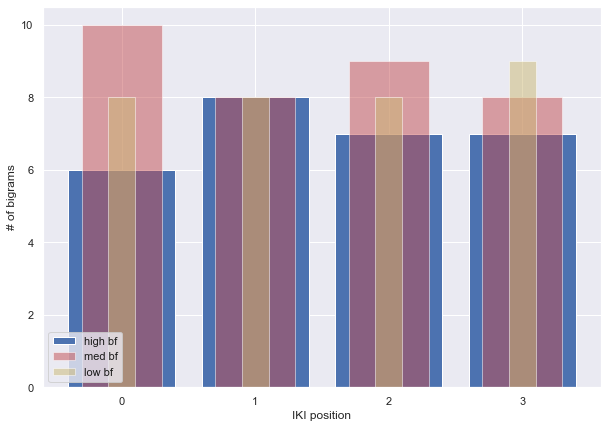

In [51]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

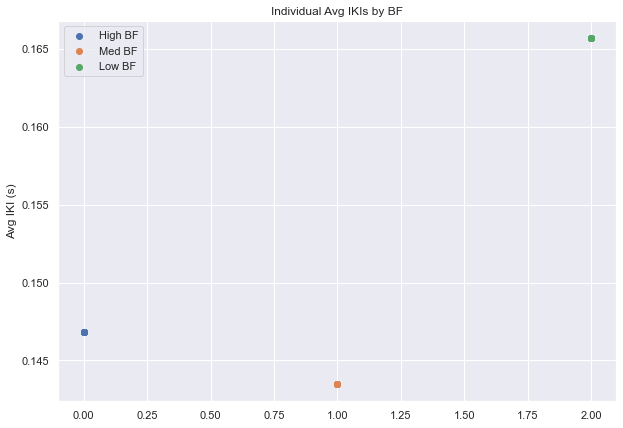

In [52]:
## Raster plot of indiv. MEAN IKI by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter([0] * len(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'], 
                              label='High BF')
medbf_scatter = plt.scatter([1] * len(indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI'], 
                              label='Med BF')
Lowbf_scatter = plt.scatter([2] * len(indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI'], 
                              label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

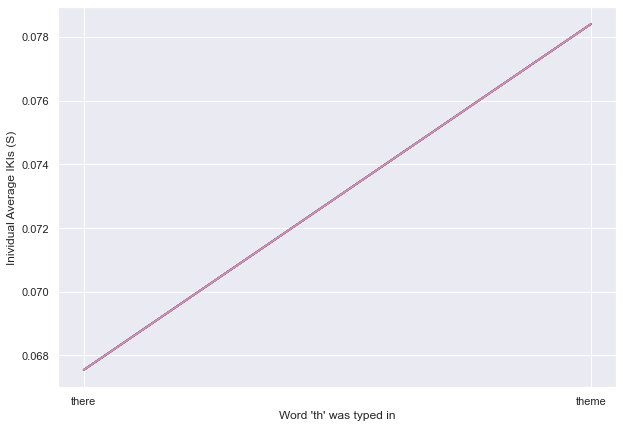

In [53]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

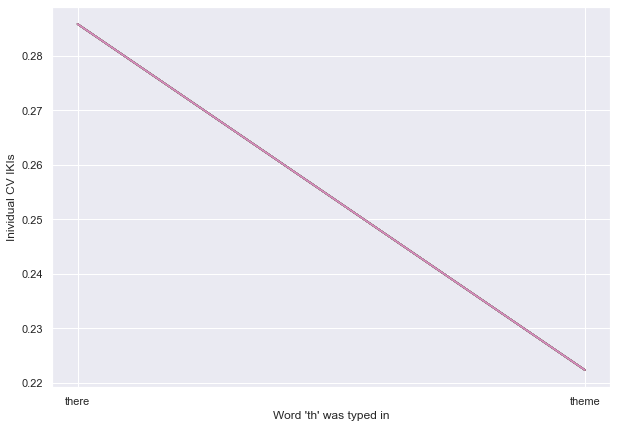

In [54]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

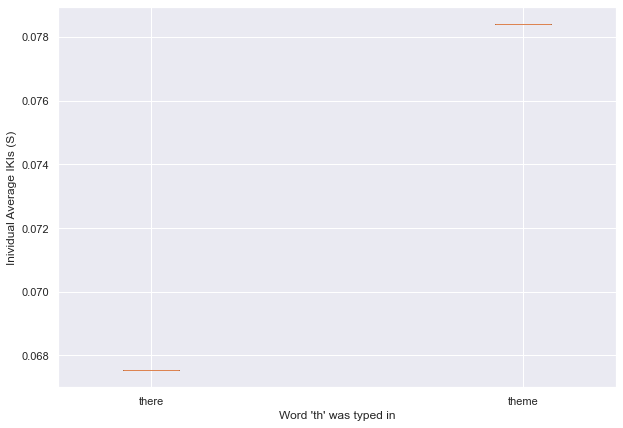

In [55]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

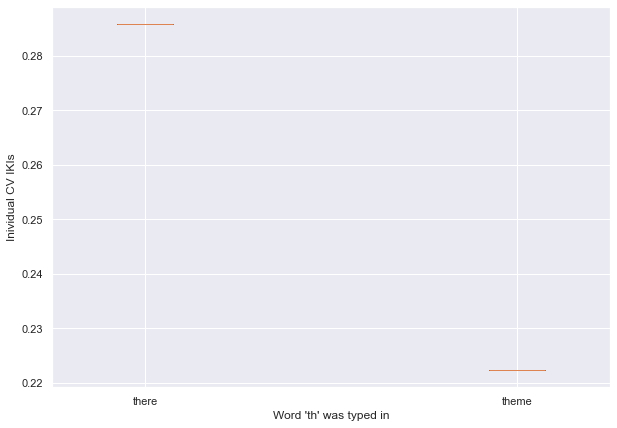

In [56]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

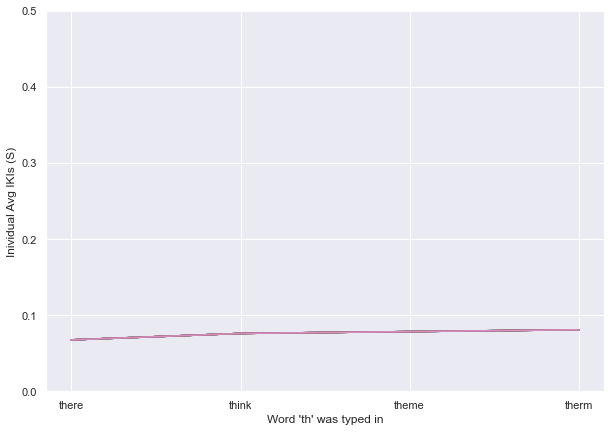

In [57]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

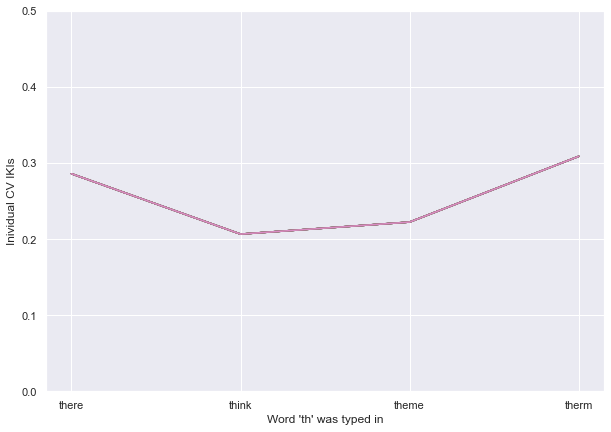

In [58]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [59]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [60]:
# ## plotting digraph latency variations by WF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig('ian_iki.png')

# plt.show()

In [61]:
# ## plotting digraph latency variations by WF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [62]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [63]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [64]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [65]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.high_avgbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.med_avgbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.low_avgbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# WIP
___

In [66]:
## running wilcoxon rank-sum test between IKI and CV IKI
# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [67]:
# def delta_iki(bigram, string):
#     all_deltas = []
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         deltas = [sub]
#         for trial in range(0, len(sub_df) - 1):
#             deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
#         all_deltas.append(deltas)
#     all_deltas = pd.DataFrame(all_deltas)
#     all_deltas = all_deltas.transpose()
#     return all_deltas

In [68]:
# def iki_change_bysub(bigram, string):
#     all_subs = pd.DataFrame()
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         ikis = sub_df['IKI'].tolist()
#         while len(ikis) != 10:
#             ikis.append(np.nan)
#         all_subs[sub] = ikis
#     return all_subs
        
# iki_change_bysub('pu', 'puppy')

In [69]:
##plotting IKI accross repetitions for each individual

# df = iki_change_bysub('pu', 'puppy')

# df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Repetition #")
# plt.ylabel("IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend().remove()

# plt.show()

In [70]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

# plt.figure(figsize=(10, 7))
# for bg in typ.lowbf:
#     by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
#     rep_ikis = []
#     for n in range(0, 9):
#         all_reps = by_bg[by_bg['rep #'] == n]
#         avg_iki_byrep = all_reps['IKI'].mean()
#         rep_ikis.append(avg_iki_byrep)

#         plt.plot(rep_ikis)

#         # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
#         plt.xlabel("Repetition #")
#         plt.ylabel("Avg IKI (s)")
#         # plt.ylim([0, 0.8])
#         plt.title("")
#         # plt.legend().remove()

# plt.show()

In [71]:
# yk_df = delta_iki('dk', 'vodka')[1:]

# yk_df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Inter-repetition position")
# plt.ylabel("Delta IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend(loc="best")

# plt.show()

In [72]:
# def indiv_means_bgonly(bigram):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgonly(bigram):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

In [73]:
# all_indiv_means = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

# all_indiv_cvs = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

In [74]:
## plot of individual avg iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_means[all_indiv_means.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 0.4])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [75]:
## plot of individual cv iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['CV IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [76]:
# th_means = pd.concat([indiv_means_bybg('there', 'th'), indiv_means_bybg('think', 'th'), indiv_means_bybg('theme', 'th'), indiv_means_bybg('therm', 'th')]
#                      , ignore_index=True)
# print(th_means)

# # print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [77]:
# th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
#                      , ignore_index=True)

# print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [78]:
# th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [79]:
# th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [80]:
# th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [81]:
# th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())